# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
# Importing the file porter_data_1.csv

df = pd.read_csv('porter_data_1.csv')

In [4]:
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [56]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [57]:
# Convert categorical features to category type
market_ids = pd.get_dummies(df['market_id'], prefix='market_id', drop_first=True)
order_protocols = pd.get_dummies(df['order_protocol'], prefix='order_protocol', drop_first=True)

df = pd.concat([df, market_ids,order_protocols], axis=1)

count_map = df['store_primary_category'].value_counts()
df['store_primary_category_encoded'] = df['store_primary_category'].map(count_map)

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [58]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df['time_taken']

0         47.0
1         44.0
2         55.0
3         59.0
4         46.0
          ... 
175772    43.0
175773    62.0
175774    46.0
175775    45.0
175776    37.0
Name: time_taken, Length: 175777, dtype: float64

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [59]:
# Extract the hour and day of week from the 'created_at' timestamp
df['created_at_hour'] = df['created_at'].dt.hour
df['created_at_day_of_week'] = df['created_at'].dt.day_of_week

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['created_at'].dt.day_of_week >= 5

In [60]:
# Drop unnecessary columns
df = df.drop(['created_at','actual_delivery_time', 'market_id', 'order_protocol', 'store_primary_category'], axis=1)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [61]:
# Define target variable (y) and features (X)

y = df['time_taken']
X = df.drop('time_taken',axis=1)

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [62]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
train_df = pd.concat([X_train, y_train], axis=1)

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [64]:
# Define numerical and categorical columns for easy EDA and data manipulation

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123043 entries, 94465 to 121958
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   total_items                     123043 non-null  int64  
 1   subtotal                        123043 non-null  int64  
 2   num_distinct_items              123043 non-null  int64  
 3   min_item_price                  123043 non-null  int64  
 4   max_item_price                  123043 non-null  int64  
 5   total_onshift_dashers           123043 non-null  float64
 6   total_busy_dashers              123043 non-null  float64
 7   total_outstanding_orders        123043 non-null  float64
 8   distance                        123043 non-null  float64
 9   market_id_2.0                   123043 non-null  bool   
 10  market_id_3.0                   123043 non-null  bool   
 11  market_id_4.0                   123043 non-null  bool   
 12  market_id_5.0    

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

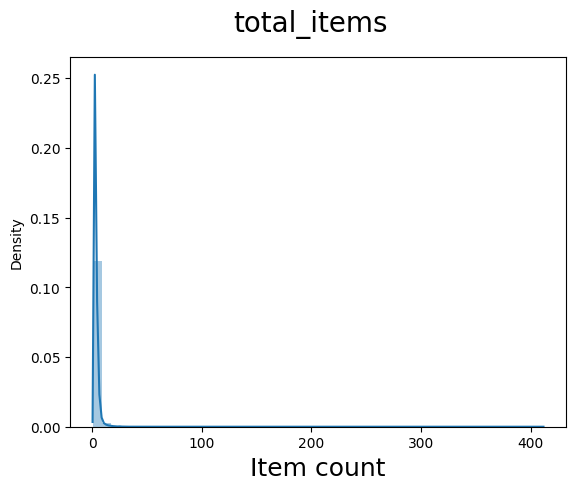

In [65]:
# Plot distributions for all numerical columns

fig = plt.figure()
sns.distplot(train_df['total_items'])
fig.suptitle('total_items', fontsize = 20)
plt.xlabel('Item count', fontsize = 18)
plt.show()

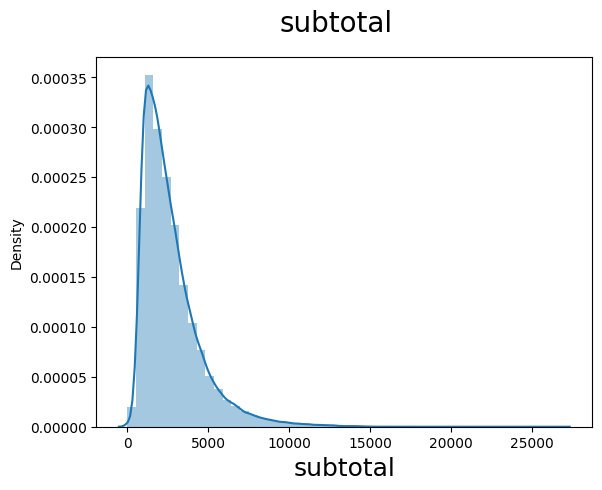

In [66]:
fig = plt.figure()
sns.distplot(train_df['subtotal'])
fig.suptitle('subtotal', fontsize = 20)
plt.xlabel('subtotal', fontsize = 18)
plt.show()

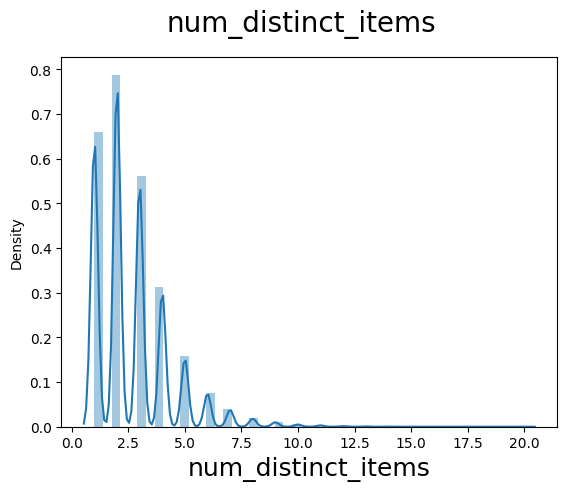

In [67]:
fig = plt.figure()
sns.distplot(train_df['num_distinct_items'])
fig.suptitle('num_distinct_items', fontsize = 20)
plt.xlabel('num_distinct_items', fontsize = 18)
plt.show()

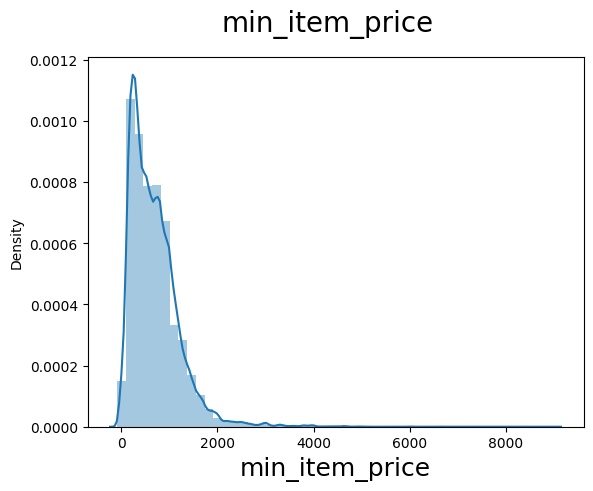

In [68]:
fig = plt.figure()
sns.distplot(train_df['min_item_price'])
fig.suptitle('min_item_price', fontsize = 20)
plt.xlabel('min_item_price', fontsize = 18)
plt.show()

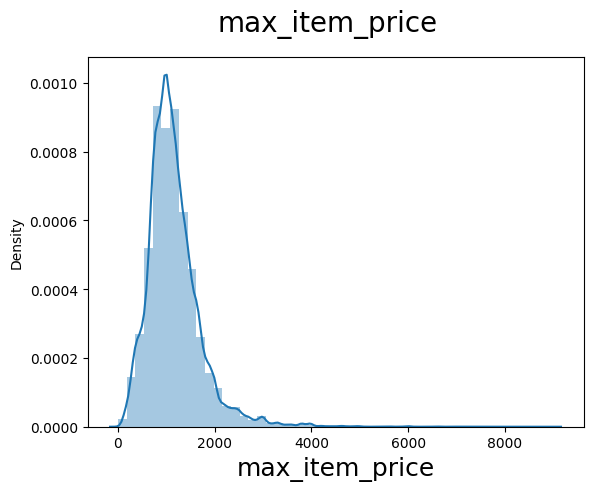

In [69]:
fig = plt.figure()
sns.distplot(train_df['max_item_price'])
fig.suptitle('max_item_price', fontsize = 20)
plt.xlabel('max_item_price', fontsize = 18)
plt.show()

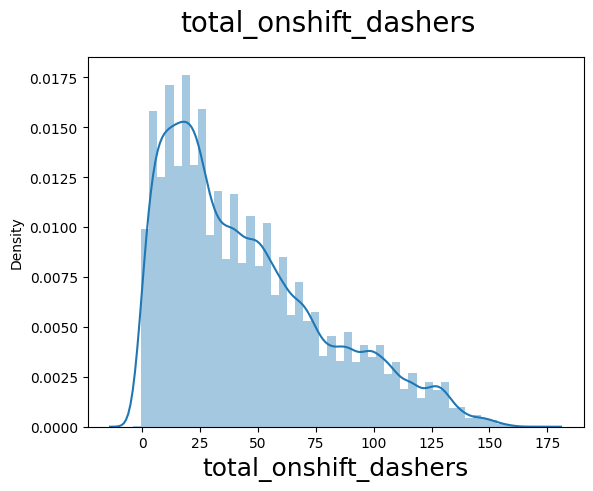

In [70]:
fig = plt.figure()
sns.distplot(train_df['total_onshift_dashers'])
fig.suptitle('total_onshift_dashers', fontsize = 20)
plt.xlabel('total_onshift_dashers', fontsize = 18)
plt.show()

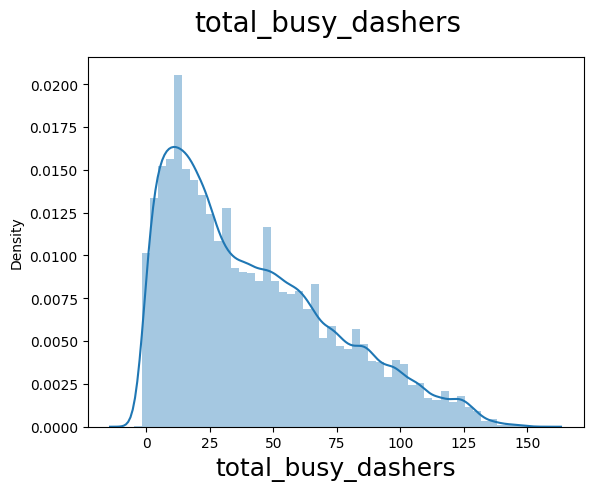

In [71]:
fig = plt.figure()
sns.distplot(train_df['total_busy_dashers'])
fig.suptitle('total_busy_dashers', fontsize = 20)
plt.xlabel('total_busy_dashers', fontsize = 18)
plt.show()

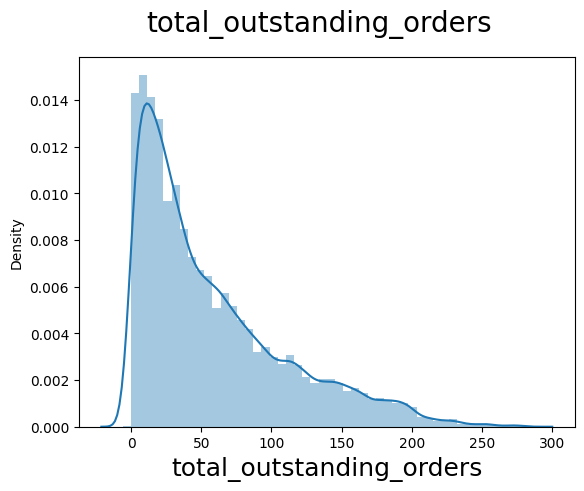

In [72]:
fig = plt.figure()
sns.distplot(train_df['total_outstanding_orders'])
fig.suptitle('total_outstanding_orders', fontsize = 20)
plt.xlabel('total_outstanding_orders', fontsize = 18)
plt.show()

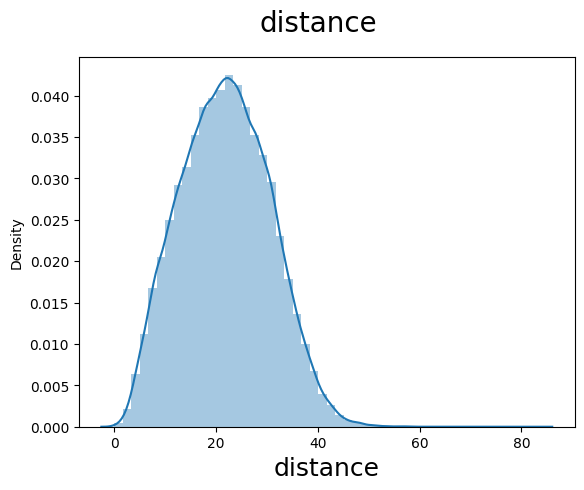

In [73]:
fig = plt.figure()
sns.distplot(train_df['distance'])
fig.suptitle('distance', fontsize = 20)
plt.xlabel('distance', fontsize = 18)
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

In [74]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123043 entries, 94465 to 121958
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   total_items                     123043 non-null  int64  
 1   subtotal                        123043 non-null  int64  
 2   num_distinct_items              123043 non-null  int64  
 3   min_item_price                  123043 non-null  int64  
 4   max_item_price                  123043 non-null  int64  
 5   total_onshift_dashers           123043 non-null  float64
 6   total_busy_dashers              123043 non-null  float64
 7   total_outstanding_orders        123043 non-null  float64
 8   distance                        123043 non-null  float64
 9   market_id_2.0                   123043 non-null  bool   
 10  market_id_3.0                   123043 non-null  bool   
 11  market_id_4.0                   123043 non-null  bool   
 12  market_id_5.0    

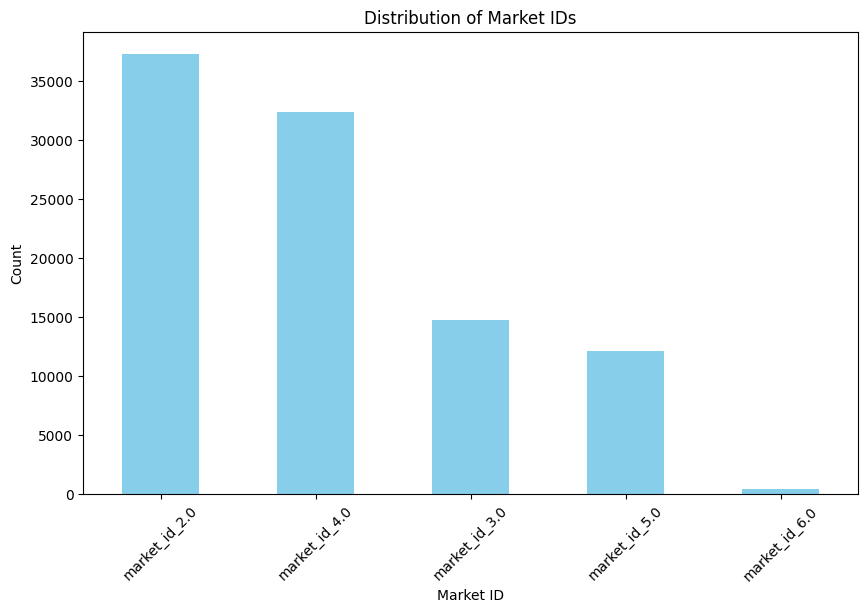

In [75]:
# Distribution of categorical columns

cols_to_plot = ['market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0']
market_counts = train_df[cols_to_plot].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
market_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Market IDs')
plt.ylabel('Count')
plt.xlabel('Market ID')
plt.xticks(rotation=45)
plt.show()

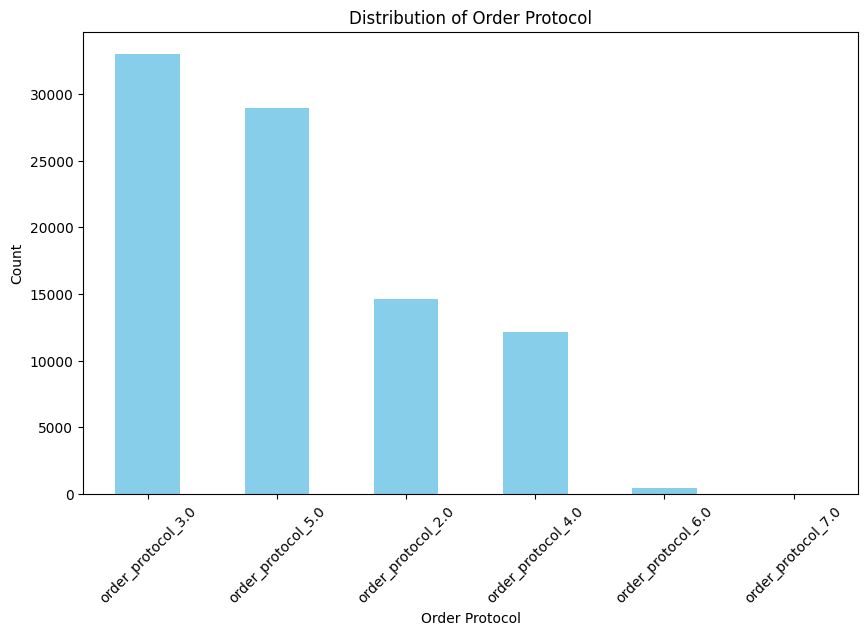

In [76]:
cols_to_plot = ['order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0']
order_protocol_counts = train_df[cols_to_plot].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
order_protocol_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Order Protocol')
plt.ylabel('Count')
plt.xlabel('Order Protocol')
plt.xticks(rotation=45)
plt.show()

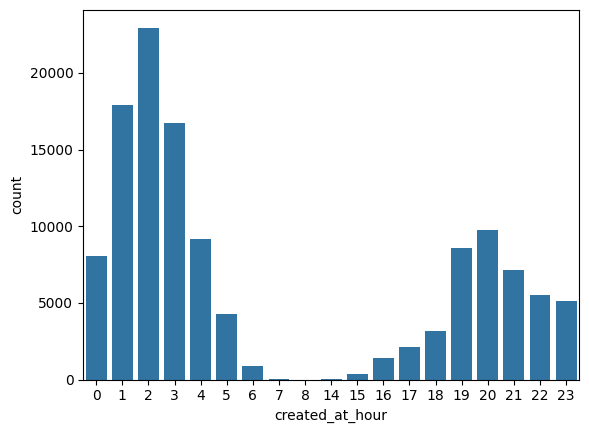

In [77]:
fig = plt.figure()
sns.barplot(x = 'created_at_hour',y= 'count',data=train_df['created_at_hour'].value_counts().reset_index())
plt.xlabel('created_at_hour')
plt.show()

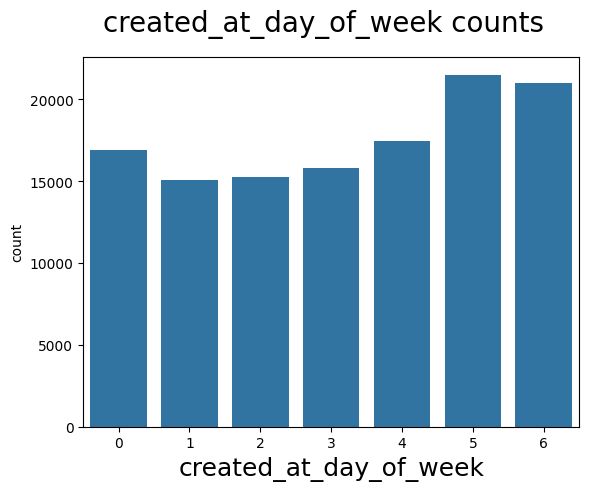

In [78]:
fig = plt.figure()
sns.barplot(x = 'created_at_day_of_week',y= 'count',data=train_df['created_at_day_of_week'].value_counts().reset_index())
fig.suptitle('created_at_day_of_week counts', fontsize = 20)
plt.xlabel('created_at_day_of_week', fontsize = 18)
plt.show()

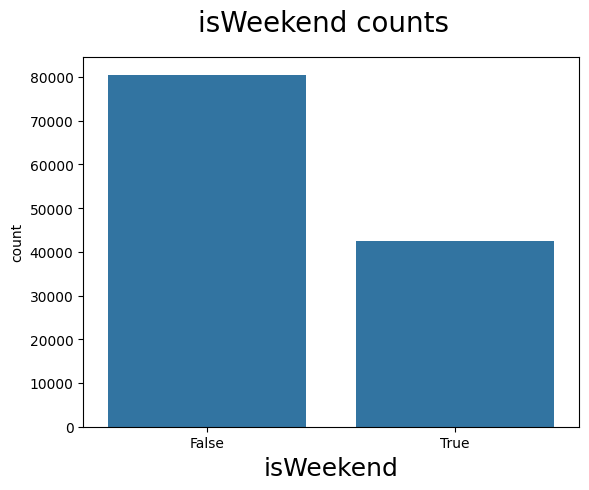

In [79]:
fig = plt.figure()
sns.barplot(x = 'isWeekend',y= 'count',data=train_df['isWeekend'].value_counts().reset_index())
fig.suptitle('isWeekend counts', fontsize = 20)
plt.xlabel('isWeekend', fontsize = 18)
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

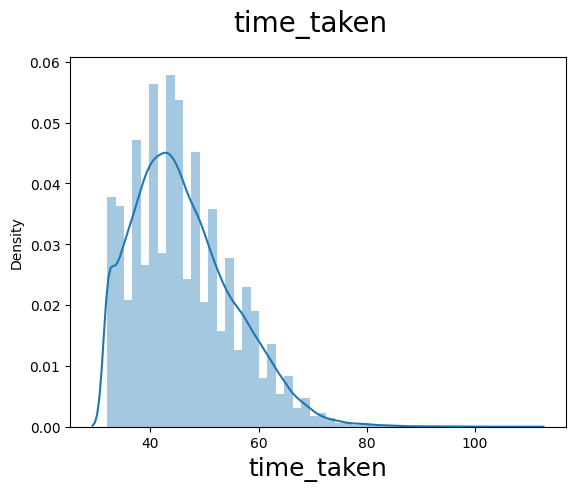

In [80]:
# Distribution of time_taken

fig = plt.figure()
sns.distplot(train_df['time_taken'])
fig.suptitle('time_taken', fontsize = 20)
plt.xlabel('time_taken', fontsize = 18)
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

In [81]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123043 entries, 94465 to 121958
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   total_items                     123043 non-null  int64  
 1   subtotal                        123043 non-null  int64  
 2   num_distinct_items              123043 non-null  int64  
 3   min_item_price                  123043 non-null  int64  
 4   max_item_price                  123043 non-null  int64  
 5   total_onshift_dashers           123043 non-null  float64
 6   total_busy_dashers              123043 non-null  float64
 7   total_outstanding_orders        123043 non-null  float64
 8   distance                        123043 non-null  float64
 9   market_id_2.0                   123043 non-null  bool   
 10  market_id_3.0                   123043 non-null  bool   
 11  market_id_4.0                   123043 non-null  bool   
 12  market_id_5.0    

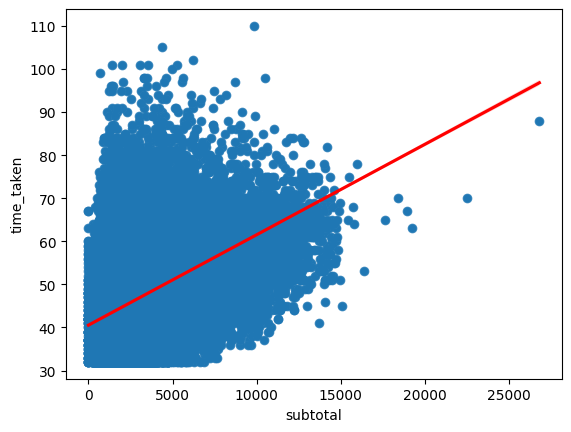

In [82]:
# Scatter plot to visualise the relationship between time_taken and other features

sns.scatterplot(data=train_df, x="subtotal", y="time_taken")
sns.regplot(data=train_df, x="subtotal", y="time_taken", line_kws={"color": "red"})
plt.show()

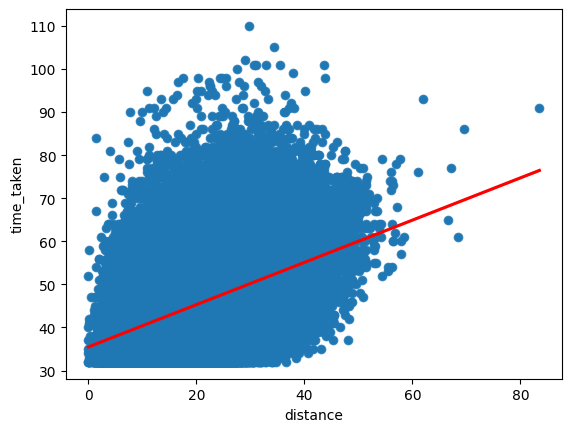

In [83]:
sns.scatterplot(data=train_df, x="distance", y="time_taken")
sns.regplot(data=train_df, x="distance", y="time_taken", line_kws={"color": "red"})
plt.show()

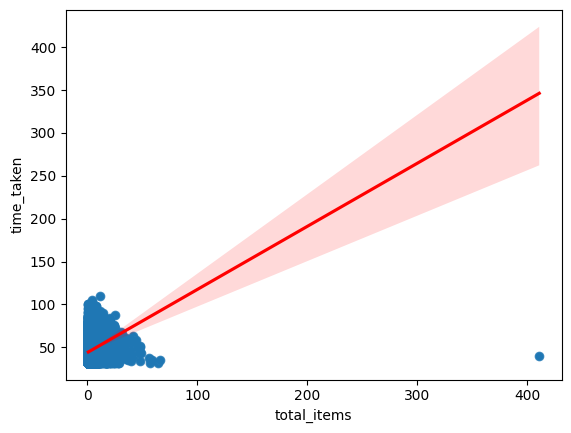

In [84]:
sns.scatterplot(data=train_df, x="total_items", y="time_taken")
sns.regplot(data=train_df, x="total_items", y="time_taken", line_kws={"color": "red"})
plt.show()

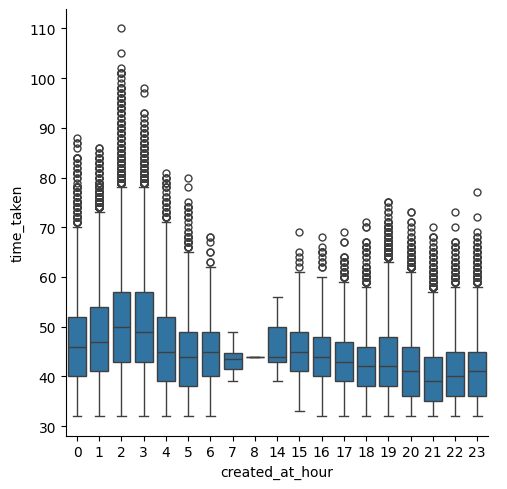

In [85]:
# Show the distribution of time_taken for different hours
sns.catplot(x='created_at_hour', y='time_taken', data=train_df, kind='box')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123043 entries, 94465 to 121958
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   total_items                     123043 non-null  int64  
 1   subtotal                        123043 non-null  int64  
 2   num_distinct_items              123043 non-null  int64  
 3   min_item_price                  123043 non-null  int64  
 4   max_item_price                  123043 non-null  int64  
 5   total_onshift_dashers           123043 non-null  float64
 6   total_busy_dashers              123043 non-null  float64
 7   total_outstanding_orders        123043 non-null  float64
 8   distance                        123043 non-null  float64
 9   market_id_2.0                   123043 non-null  bool   
 10  market_id_3.0                   123043 non-null  bool   
 11  market_id_4.0                   123043 non-null  bool   
 12  market_id_5.0    

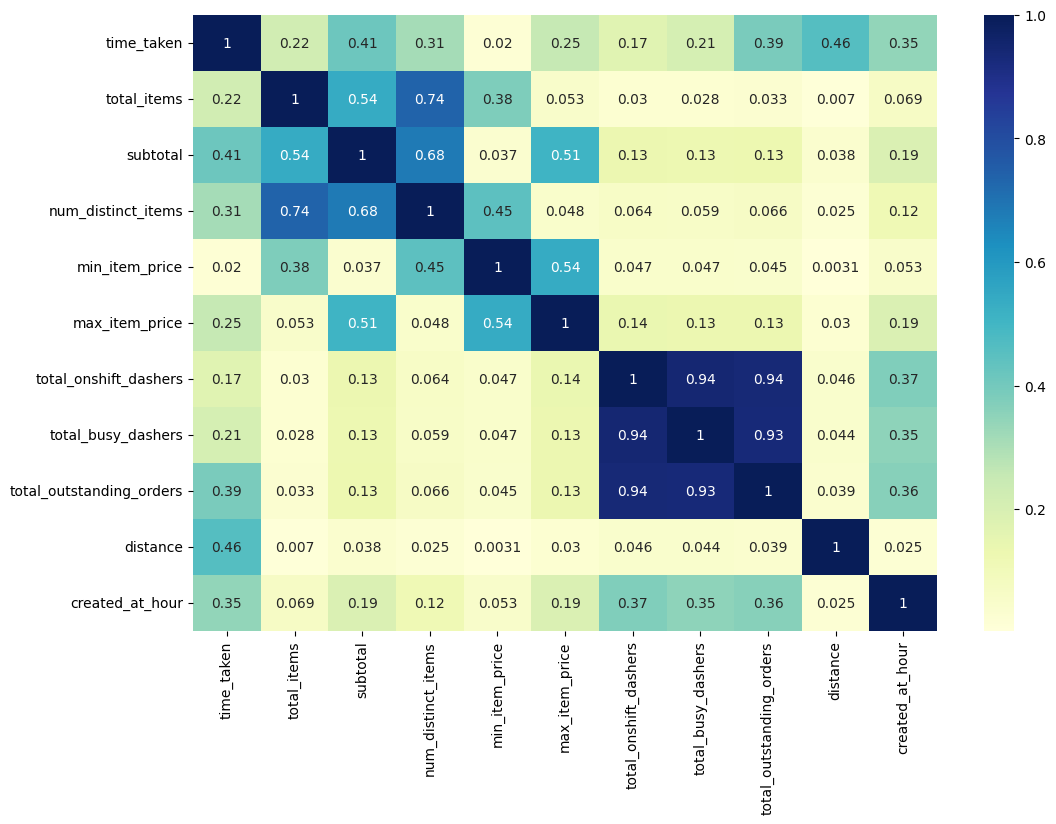

In [87]:
# Plot the heatmap of the correlation matrix
numerical_features = ['time_taken','total_items','subtotal','num_distinct_items','min_item_price','max_item_price','total_onshift_dashers','total_busy_dashers','total_outstanding_orders','distance','created_at_hour']

plt.figure(figsize=(12, 8))
sns.heatmap(train_df[numerical_features].corr().abs(), annot=True,cmap="YlGnBu")
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [88]:
# Drop 3-5 weakly correlated columns from training dataset
drop_cols = ['min_item_price','total_onshift_dashers','total_busy_dashers','total_items','max_item_price']
train_df = train_df.drop(drop_cols, axis=1)

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

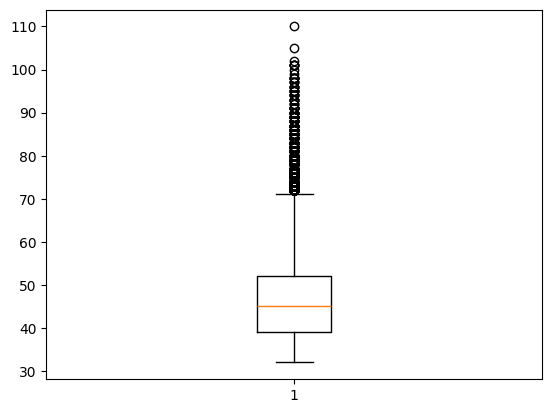

In [89]:
# Boxplot for time_taken

plt.boxplot(train_df['time_taken'])
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

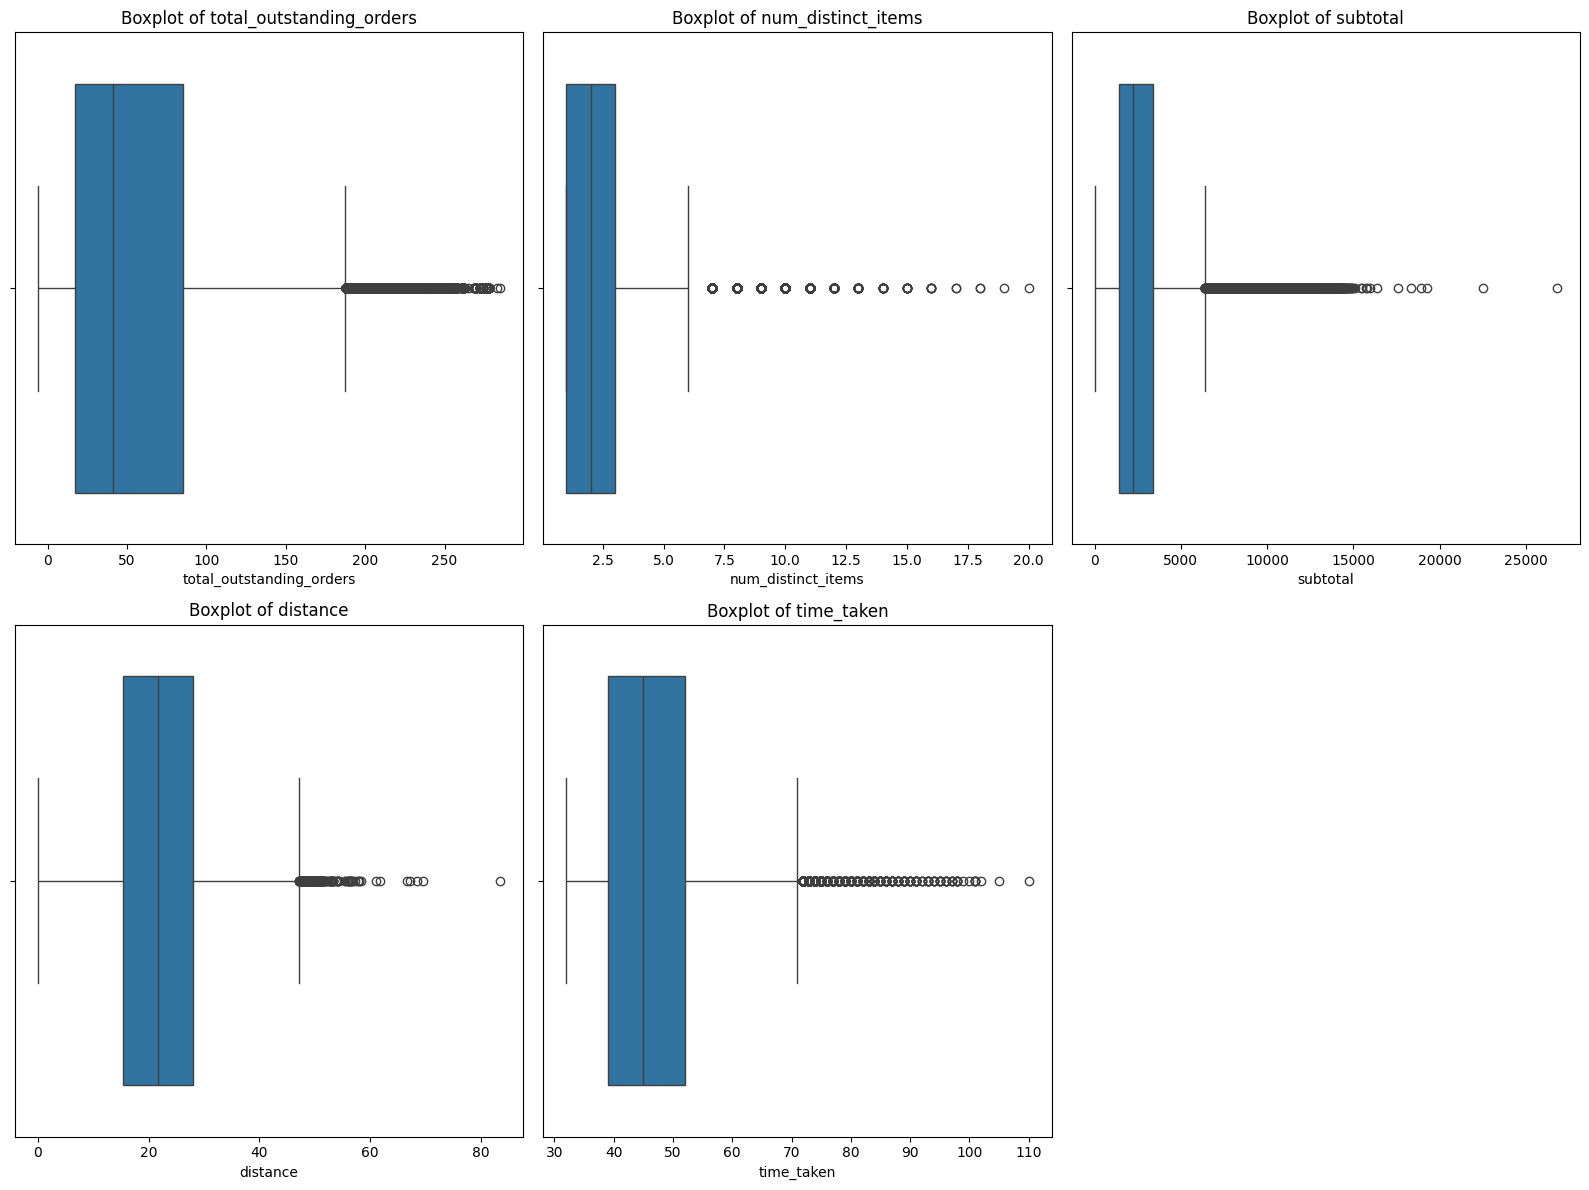

In [90]:
# Handle outliers

check_outliers_cols = ['total_outstanding_orders', 'num_distinct_items', 'subtotal', 'distance','time_taken']
plt.figure(figsize=(16, 12))

for i, col in enumerate(check_outliers_cols, 1):
    plt.subplot(2, 3, i) 
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

In [91]:
for col in check_outliers_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]

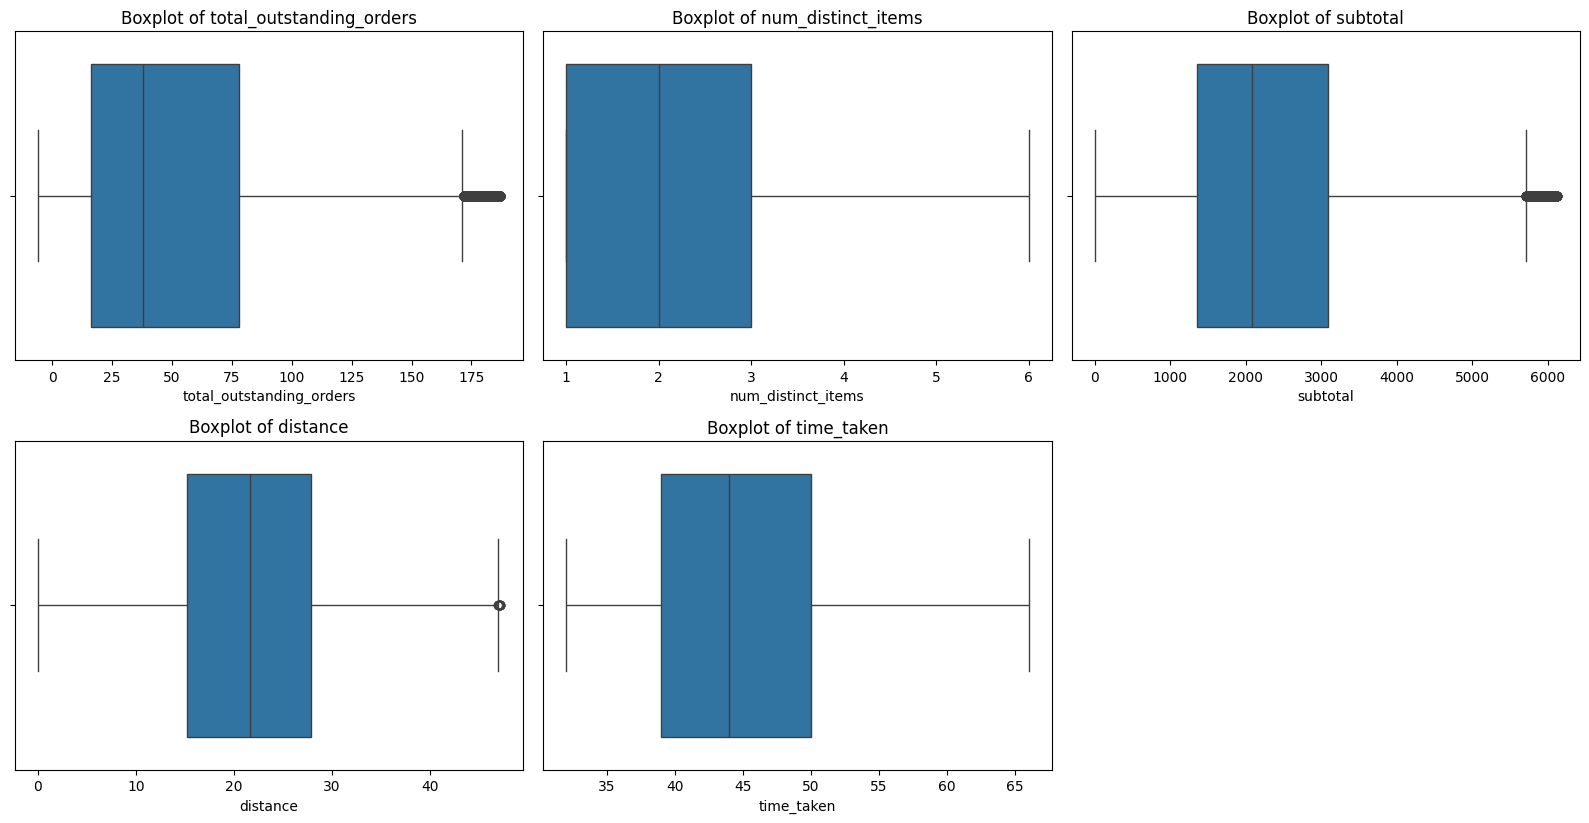

In [92]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(check_outliers_cols, 1):
    plt.subplot(3, 3, i) 
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [93]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [94]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [95]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [96]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [97]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [98]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [131]:
# Import libraries

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [100]:
train_df.describe()

subtotal  num_distinct_items  total_outstanding_orders  \
count  109736.000000       109736.000000             109736.000000   
mean     2342.789267            2.421776                 52.437878   
std      1247.248958            1.255338                 45.481340   
min         0.000000            1.000000                 -6.000000   
25%      1350.000000            1.000000                 16.000000   
50%      2088.000000            2.000000                 38.000000   
75%      3095.000000            3.000000                 78.000000   
max      6120.000000            6.000000                187.000000   

            distance  store_primary_category_encoded  created_at_hour  \
count  109736.000000                   109736.000000    109736.000000   
mean       21.608355                     8803.477783         8.927626   
std         8.601240                     5544.158152         8.796131   
min         0.000000                        1.000000         0.000000   
25%        15.160000                     4841.000000         2.000000   
50%        21.600000                     8085.000000         3.000000   
75%        27.880000                    15586.000000        19.000000   
max        47.160000                    18183.000000        23.000000   

       created_at_day_of_week     time_taken  
count           109736.000000  109736.000000  
mean                 3.213986      44.667794  
std                  2.024710       7.953452  
min                  0.000000      32.000000  
25%                  1.000000      39.000000  
50%                  3.000000      44.000000  
75%                  5.000000      50.000000  
max                  6.000000      66.000000

In [101]:
# Apply scaling to the numerical columns

scaling_cols = ['subtotal','num_distinct_items','total_outstanding_orders','distance','store_primary_category_encoded','created_at_hour','created_at_day_of_week']
scaler = MinMaxScaler()
train_df[scaling_cols] = scaler.fit_transform(train_df[scaling_cols])

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [102]:
# Create/Initialise the model

y_train = train_df['time_taken']
X_train = train_df.drop('time_taken', axis=1)
X_train = sm.add_constant(X_train)
X_train[X_train.select_dtypes(include='bool').columns] = X_train.select_dtypes(include='bool').astype(int)

In [104]:
# Train the model using the training data

lm_1 = sm.OLS(y_train,X_train).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     8159.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:38:58   Log-Likelihood:            -3.3493e+05
No. Observations:              109736   AIC:                         6.699e+05
Df Residuals:                  109716   BIC:                         6.701e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [107]:
X_train.columns, X_test.columns

(Index(['const', 'subtotal', 'num_distinct_items', 'total_outstanding_orders',
        'distance', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
        'market_id_5.0', 'market_id_6.0', 'order_protocol_2.0',
        'order_protocol_3.0', 'order_protocol_4.0', 'order_protocol_5.0',
        'order_protocol_6.0', 'order_protocol_7.0',
        'store_primary_category_encoded', 'created_at_hour',
        'created_at_day_of_week', 'isWeekend'],
       dtype='object'),
 Index(['subtotal', 'num_distinct_items', 'total_outstanding_orders',
        'distance', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
        'market_id_5.0', 'market_id_6.0', 'order_protocol_2.0',
        'order_protocol_3.0', 'order_protocol_4.0', 'order_protocol_5.0',
        'order_protocol_6.0', 'order_protocol_7.0',
        'store_primary_category_encoded', 'created_at_hour',
        'created_at_day_of_week', 'isWeekend'],
       dtype='object'))

In [108]:
# Make predictions

X_test[scaling_cols] = scaler.transform(X_test[scaling_cols])
X_test[X_test.select_dtypes(include='bool').columns] = X_test.select_dtypes(include='bool').astype(int)
X_test = X_test.drop(drop_cols, axis=1)
X_test = sm.add_constant(X_test)

y_train_pred = lm_1.predict(X_train)
y_test_pred = lm_1.predict(X_test)

Text(0, 0.5, 'y_pred')

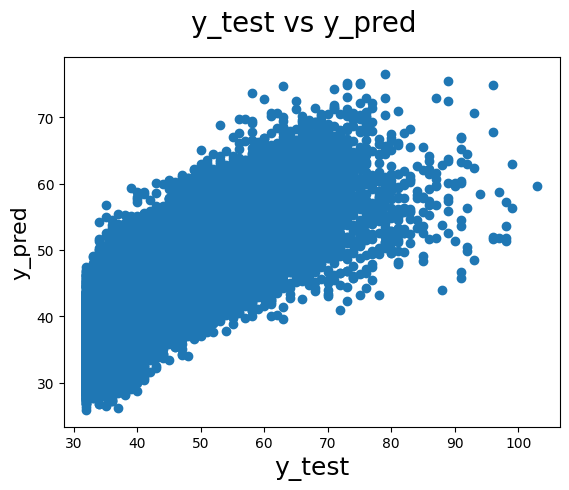

In [109]:
# Find results for evaluation metrics

fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)    
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

In [113]:
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

Mean Absolute Error: 4.3684
Mean Squared Error: 33.0114
R2 Score: 0.6221


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [128]:
# Loop through the number of features and test the model

rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
_ = rfe.fit(X_train, y_train)

In [123]:
rfe_results_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': rfe.support_,
    'Rank': rfe.ranking_
})

rfe_results_df = rfe_results_df.sort_values(by='Rank').reset_index(drop=True)

rfe_results_df

Feature  Selected  Rank
0                    market_id_6.0      True     1
1                  created_at_hour      True     1
2                    market_id_5.0      True     1
3                    market_id_4.0      True     1
4                    market_id_3.0      True     1
5                        isWeekend      True     1
6                         distance      True     1
7         total_outstanding_orders      True     1
8                         subtotal      True     1
9                    market_id_2.0      True     1
10          created_at_day_of_week     False     2
11              order_protocol_5.0     False     3
12              num_distinct_items     False     4
13              order_protocol_4.0     False     5
14              order_protocol_3.0     False     6
15              order_protocol_6.0     False     7
16              order_protocol_2.0     False     8
17              order_protocol_7.0     False     9
18  store_primary_category_encoded     False    10
19                           const     False    11

In [130]:
cols_to_drop = ['num_distinct_items', 'order_protocol_4.0', 'order_protocol_3.0', 'order_protocol_6.0', 'order_protocol_2.0', 'order_protocol_7.0', 'store_primary_category_encoded']
X_train = X_train.drop(cols_to_drop,axis=1)

In [132]:
vif = pd.DataFrame()
X = X_train.copy()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                      const  20.70
12                 isWeekend   2.85
11    created_at_day_of_week   2.84
4              market_id_2.0   2.05
6              market_id_4.0   1.99
2   total_outstanding_orders   1.72
5              market_id_3.0   1.41
7              market_id_5.0   1.35
10           created_at_hour   1.25
1                   subtotal   1.07
9         order_protocol_5.0   1.03
3                   distance   1.01
8              market_id_6.0   1.01

In [135]:
# Build the final model with selected number of features

lm_2 = sm.OLS(y_train,X_train).fit()
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 1.238e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:41:21   Log-Likelihood:            -3.3629e+05
No. Observations:              109736   AIC:                         6.726e+05
Df Residuals:                  109723   BIC:                         6.727e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [143]:
X_train.columns, X_test.columns

(Index(['const', 'subtotal', 'total_outstanding_orders', 'distance',
        'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
        'market_id_6.0', 'order_protocol_5.0', 'created_at_hour',
        'created_at_day_of_week', 'isWeekend'],
       dtype='object'),
 Index(['const', 'subtotal', 'total_outstanding_orders', 'distance',
        'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
        'market_id_6.0', 'order_protocol_5.0', 'created_at_hour',
        'created_at_day_of_week', 'isWeekend'],
       dtype='object'))

Text(0, 0.5, 'y_pred')

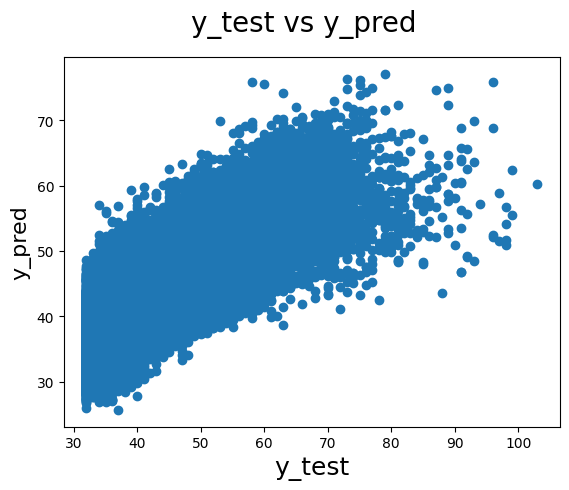

In [144]:
X_test = X_test.drop(cols_to_drop,axis=1)
y_test_pred = lm_2.predict(X_test)
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)    
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

In [145]:
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

Mean Absolute Error: 4.4223
Mean Squared Error: 33.7064
R2 Score: 0.6141


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

Text(0.5, 0, 'Errors')

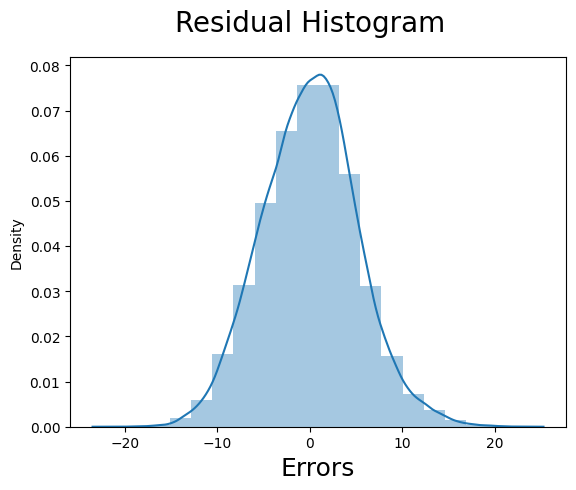

In [139]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

y_train_price = lm_2.predict(X_train)

fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Residual Histogram', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

Text(0.5, 0, 'Errors')

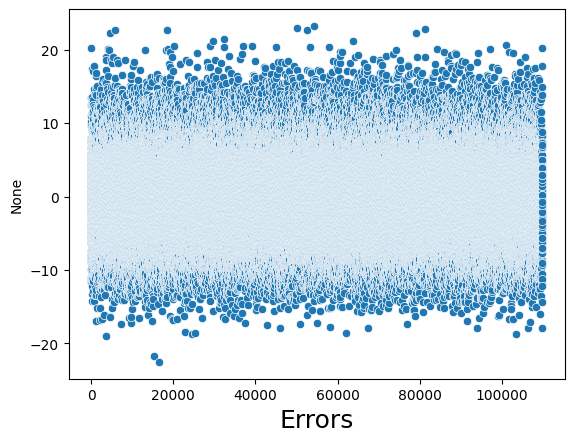

In [138]:
fig = plt.figure()
sns.scatterplot(x=range(len(y_train)), y= y_train - y_train_pred)
plt.xlabel('Errors', fontsize = 18)

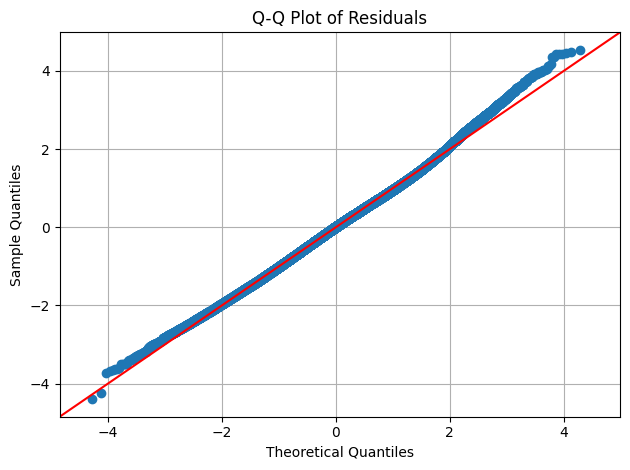

In [140]:
fig = sm.qqplot(y_train - y_train_pred, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [161]:
# Compare the scaled vs unscaled features used in the final model

print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 1.238e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:12:25   Log-Likelihood:            -3.3629e+05
No. Observations:              109736   AIC:                         6.726e+05
Df Residuals:                  109723   BIC:                         6.727e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [162]:
scaled_coef = {'subtotal':9.5791,'total_outstanding_orders':12.2798,'distance':21.7091,'created_at_hour':-2.8489,'created_at_day_of_week':-2.6444}
unscaled_coef = {'market_id_2.0':-7.9558,  'market_id_3.0':-4.0251,  'market_id_4.0':-6.1521,  'market_id_5.0':-3.5685,  'market_id_6.0':-4.1324,  'order_protocol_5.0':-2.3970,  'isWeekend':3.1219}

[]

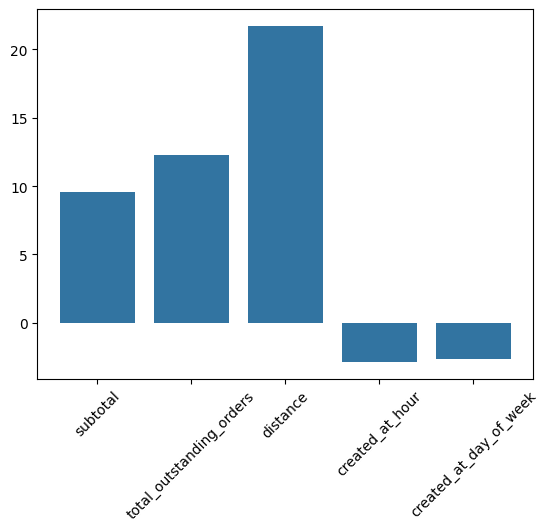

In [164]:
sns.barplot(scaled_coef)
plt.xticks(rotation=45)
plt.plot()

[]

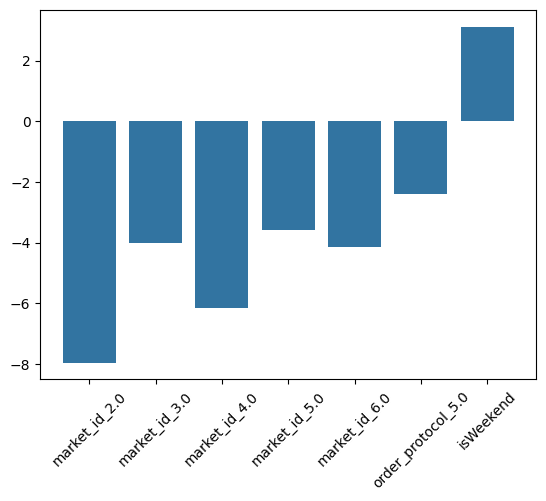

In [165]:
sns.barplot(unscaled_coef)
plt.xticks(rotation=45)
plt.plot()

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [57]:
# Analyze the effect of a unit change in a feature, say 'total_items'



Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> There are market id, order protocol and is weekend categorical features in the model. Market id and order protocol is negatively correlated but is_weekend is positively correlated with dependent variable.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> test_size = 0.2 represent that 20% of total data will be taken as test set and remaining 80% is training set.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> distance has the highest correlation of 0.46 with target variable.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> I used boxplot approch to check outliers and used Inter quantile range to address them.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> top 3 features are distance, subtotal and total_outstanding_delivery



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression is a regression statistical model, which find the best line fit to features to predict target variable. It assumes
a linear relationship between the input variable and the targaet variable. The goal is to find the coefficents that minimize the error
between predicted and actual values. It uses gradient descent to find the coeffienct for each features. the common metrics used are MSE,
R-square, Adjusted R-square.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> simple linear regression have 1 independent variable but multiple linear regression uses two or more independent variable to predict target value.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> The cost function is used to measure the error between the predicted values and the actual target values. Gradient descent is then applied to the cost function to update the coefficients iteratively, adjusting them in a way that minimizes the error in each step.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> Overfitting occurs when the model is too complex and learns the training data too well, including its noise. It performs very well on the training set but fails to generalize, leading to poor performance on the test set.
Underfitting occurs when the model is too simple to capture the underlying patterns in the data, resulting in poor performance on both the training and test sets.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual plots help identify whether the errors (residuals) are randomly distributed, which is a key assumption in regression. According to regression assumptions, the residuals should follow a normal distribution and should not display any hidden patterns.